In [10]:
from pathlib import Path
import typing as T
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy
import xarray as xr
import iris
import iris.plot
import numpy as np
import os
import textwrap
import itertools
import ants
import warnings

import sys
import os

sys.path.append('/g/data/gb02/pag548/UM_config_tools/UM_config_tools')

In [11]:
from plot_ancillaries import plot_ancils, collapse_cube

In [12]:
home_dir=os.environ['HOME']
HOME=Path(home_dir)

In [13]:
# Find all regions for a given rose-id
ROSE ='u-dq124'
REGION_DIRS = [ d for d in list((HOME / 'cylc-run' / ROSE / 'share/data/ancils/' ).glob('*')) if d.is_dir() ]
REGION_DIRS   

[PosixPath('/home/548/pag548/cylc-run/u-dq124/share/data/ancils/Flagship_ERA5to1km')]

In [14]:
# Find all resolutions for a given REGION
for r_dir in REGION_DIRS:
    RESOLUTION_DIRS = [ d for d in list((r_dir).glob('*')) if d.is_dir() ]

Plotting land_binary_mask for 1km with shape (2112, 2000)
Plotting land_binary_mask for BARRA-R2 with shape (610, 780)
Plotting land_binary_mask for 5km with shape (976, 1466)
Plotting land_binary_mask for 12km with shape (580, 780)
Plotting land_binary_mask for BARRA-R2-halo with shape (630, 800)
Plotting land_binary_mask for 12km-halo with shape (600, 800)


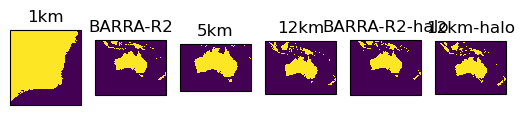

In [15]:
# quick check - plot and store land-sea masks for these resolutions
# Ignore warnings from mule  and iris 
warnings.filterwarnings('ignore',module='mule') 
warnings.filterwarnings('ignore',module='iris') 

num_plots = len(RESOLUTION_DIRS)

lsm_masks = {}

fig,ax = plt.subplots(1,num_plots,subplot_kw={'projection': ccrs.PlateCarree()})

for i,R in enumerate(RESOLUTION_DIRS):
    MASK_FILE = R / 'qrparm.mask'
    mask_cubes = ants.load(MASK_FILE)

    # Select the cube corresponding to 'land_binary_mask'
    lbm_cube, = [ cube for cube in mask_cubes if cube.name() == 'land_binary_mask'] 
    print (f'Plotting land_binary_mask for {R.name} with shape {lbm_cube.shape}')
    
    iris.plot.pcolormesh(lbm_cube,axes=ax[i])
    ax[i].set_title(f'{R.name}')

    # Store the masks for later analysis
    lsm_masks[R.name] = xr.DataArray.from_iris(lbm_cube)

In [7]:
# Now create dictionaries for all ancillary parameter files for each resolution
parm_files = {}

for i,R in enumerate(RESOLUTION_DIRS):
    
    all_files = list(R.glob('qrparm*'))

    # Filter out symlinks
    files = []
    [ files.append(f) for f in all_files if not f.is_symlink() ]

    parm_files[R.name] = files

In [8]:
# Get total list of fields for each resolution
num_plots = {}

# Loop over LAM resolutions
for res in parm_files.keys():

    count = 0
    # Loop over each ancillary parameter file for this resolution
    for file in parm_files[res]:
        #print (f'INFO : Loading {file}')
        try:
            cube = ants.load(file)
            #print (cube)
            count += len(cube)
        except:
            print (f'ERROR : Unable to open {file}\nERROR : You will have to manually check this file using "xconv" ')
            continue

    num_plots[res] = count
    print (f'There are {num_plots[res]} fields for {res}')

ERROR : Unable to open /home/548/pag548/cylc-run/u-dq124/share/data/ancils/Flagship_ERA5to1km/1km/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for 1km
ERROR : Unable to open /home/548/pag548/cylc-run/u-dq124/share/data/ancils/Flagship_ERA5to1km/BARRA-R2/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for BARRA-R2
ERROR : Unable to open /home/548/pag548/cylc-run/u-dq124/share/data/ancils/Flagship_ERA5to1km/5km/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for 5km
ERROR : Unable to open /home/548/pag548/cylc-run/u-dq124/share/data/ancils/Flagship_ERA5to1km/BARRA-R2-halo/qrparm.veg.dist
ERROR : You will have to manually check this file using "xconv" 
There are 71 fields for BARRA-R2-halo


 Plotting ancillary parameters for BARRA-R2-halo

ERROR : NaNs identified in m01s00i207,qrparm.soil
ERROR : NaNs identified in soil_hydraulic_conductivity_at_saturation,qrparm.soil
ERROR : NaNs identified in soil_porosity,qrparm.soil
ERROR : NaNs identified in soil_suction_at_saturation,qrparm.soil
ERROR : NaNs identified in volume_fraction_of_condensed_water_in_soil_at_critical_point,qrparm.soil
ERROR : NaNs identified in volume_fraction_of_condensed_water_in_soil_at_wilting_point,qrparm.soil
For qrparm.veg.func_igbp canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp canopy_height coordinate month will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate pseudo_level will be collapsed
For qrparm.veg.func_igbp leaf_area_index coordinate month will be collapsed
For qrparm.veg.func canopy_height coordinate pseudo_level will be collapsed
For qrparm.veg.func variable canopy_height coordinate time will be collapsed


KeyboardInterrupt: 

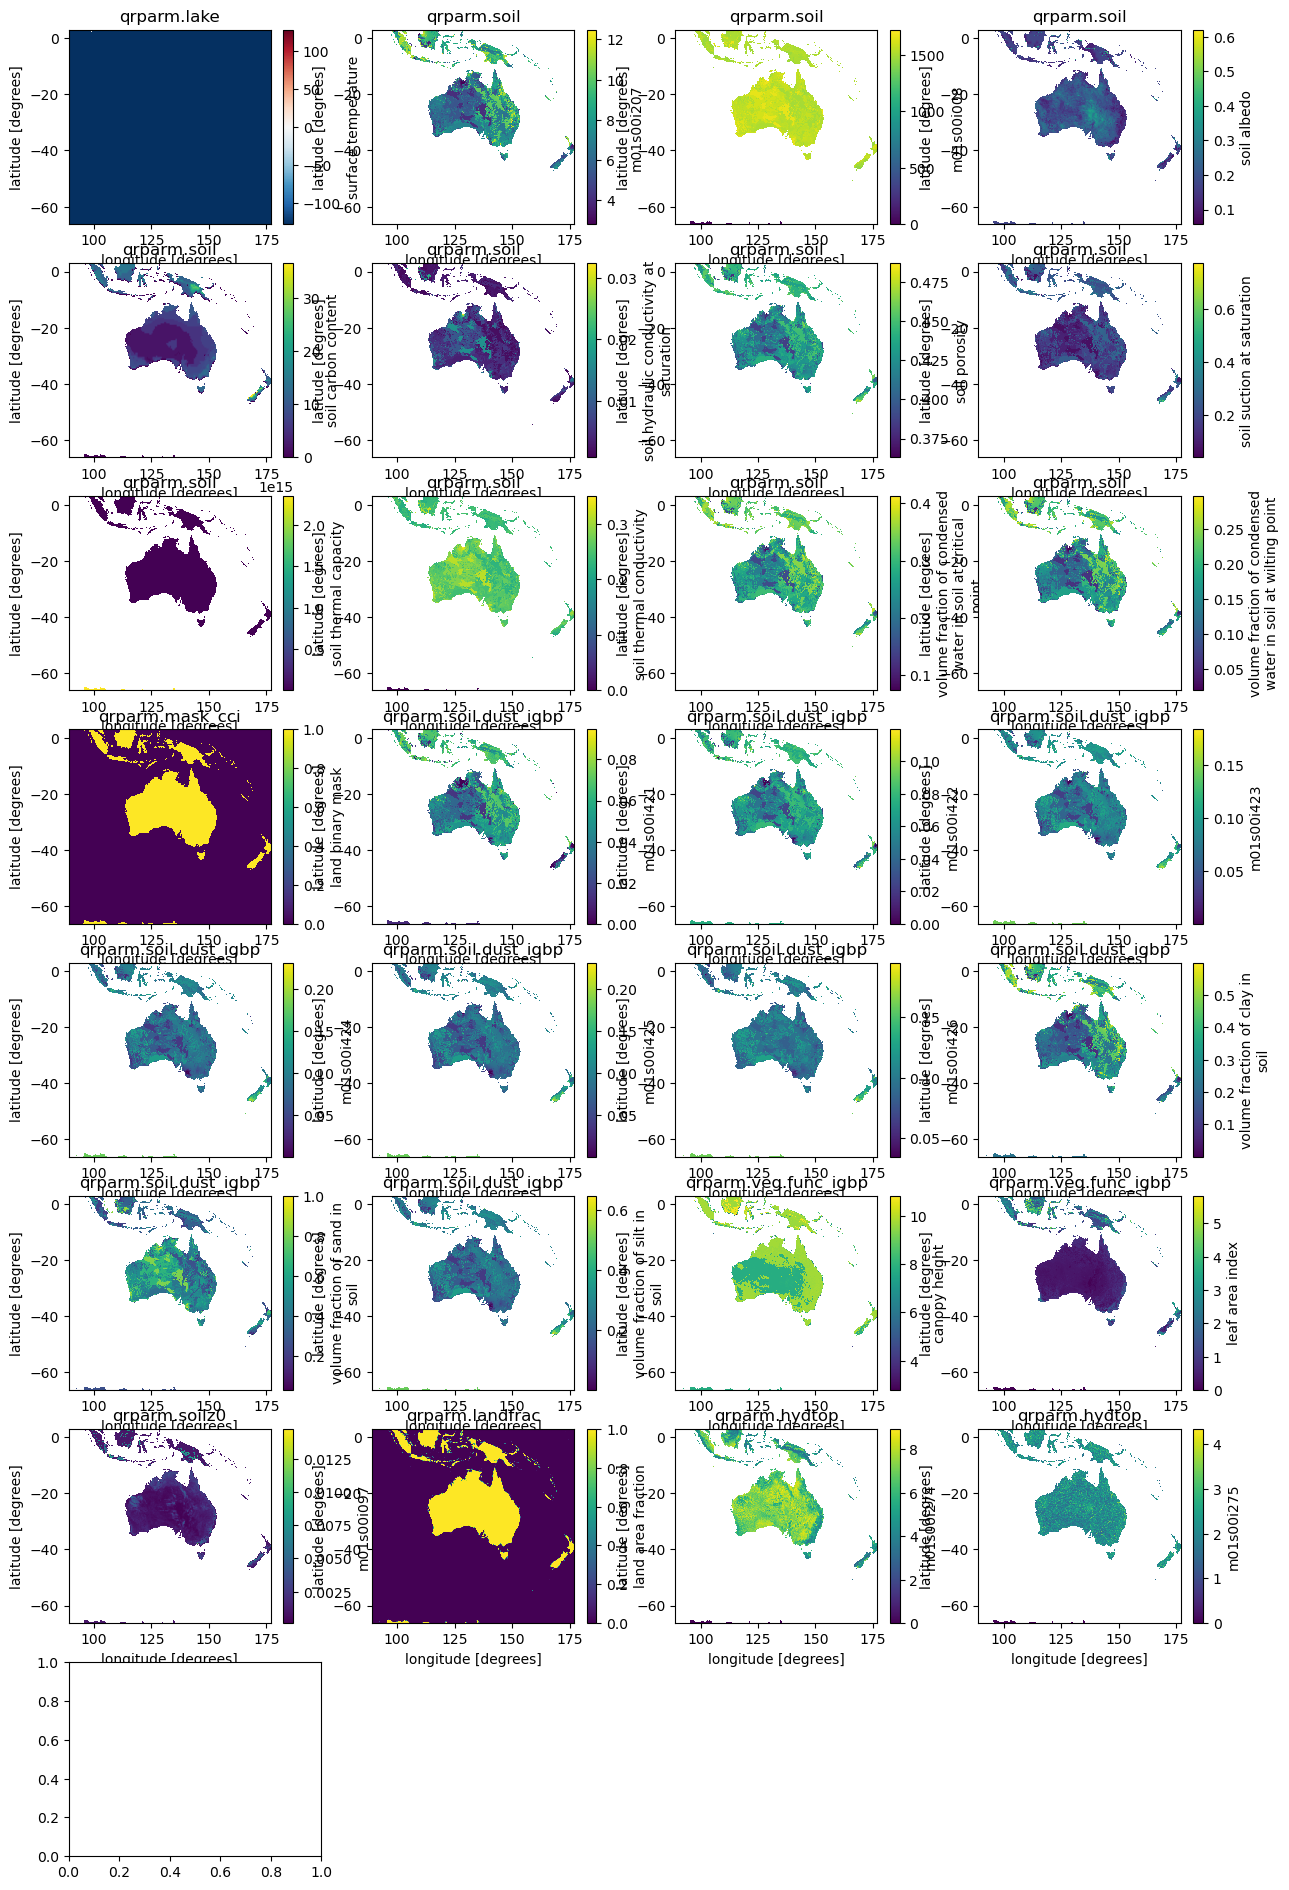

In [9]:
# Now plot for all resolutions and catch ancillary parameter fields with NaNs
bad_ancils = []

# Loop over all resolutions
#for res in parm_files.keys():
for res in ['BARRA-R2-halo']:
    nan_ancils,fig = plot_ancils(res,
                             parm_files[res],
                             lsm_masks[res],
                             num_plots[res])

    bad_ancils.extend(nan_ancils)

In [ ]:
# Now plot the bad_ancils
num_plot=len(bad_ancils)
num_columns=3
num_rows = num_plot // num_columns

if num_plot % num_columns != 0:
    num_rows += 1

Position = range(1,num_plot+1)

fig_height = num_rows*3
fig_width = 15
max_label_length=30

fig = plt.figure(figsize=(fig_width,fig_height))

k = 0

for k in range(num_plot):
     ax = fig.add_subplot(num_rows, num_columns, Position[k])
     da = bad_ancils[k]
     da.plot(ax=ax)
     ax.set_title(f'{da.name}')
plt.tight_layout()

In [ ]:
# Zoom in on NaNs. Let's do this manually for region BARRA-R2-halo, soil_porosity
# These ancils have a land-sea mask so we need to extract that
da = bad_ancils[2]
mask = lsm_masks['BARRA-R2-halo']

all_mask = mask & da.isnull()

# Find location of NaNs
all_mask.compute()
all_mask.where(all_mask.compute()==True,drop=True).compute()

In [ ]:
# Ok so we have lots of nans for 11 latitude points from longitutde 90 to 136
fig,ax=plt.subplots(2,1)
da.sel(latitude=slice(-68,-64),longitude=slice(129,136)).plot(ax=ax[0])
mask.sel(latitude=slice(-68,-64),longitude=slice(129,136)).plot(ax=ax[1])
plt.tight_layout()

In [ ]:
# So we are in the Southern Ocean. Let's plot the bad points
points = all_mask.where(all_mask.compute()==True,drop=True).compute()

In [ ]:
points

In [ ]:
file='/home/548/pag548/cylc-run/u-dq126/share/cycle/20220226T0000Z/ec/um/ec_cb000'
data = ants.load(file)

In [ ]:
data

In [ ]:
data[0]

In [ ]:
da = xr.DataArray.from_iris(data[0])

In [ ]:
da.sel(latitude=slice(-58,13),longitude=slice(88,4,208))

In [ ]:
BARRA2_DIR = Path('/g/data/ob53/BARRA2/output/reanalysis/AUS-11/BOM/ERA5/historical/hres/BARRA-R2/v1/day/tas/v20240809/')
barra_data = xr.load_dataset( BARRA2_DIR / 'tas_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_day_202411-202411.nc').tas

In [ ]:
barra_data.lon